In [2]:
# Import necessary packages

from IPython import display
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, BatchSampler
import torchvision
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime

import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, StratifiedGroupKFold, cross_val_score, GroupKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import ndcg_score as nd
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import optuna

import pytorchltr
from pytorchltr.loss import LambdaARPLoss1, LambdaARPLoss2, LambdaNDCGLoss1, LambdaNDCGLoss2, PairwiseDCGHingeLoss, PairwiseHingeLoss, PairwiseLogisticLoss
from pytorchltr.evaluation import ndcg

import operator
import statistics

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import shap

# Preprocess data

Read pointwise data

In [3]:
pointwise_data = pd.read_excel('processed_data.xlsx') # the dataset is mostly retrieved manually by Python packages

Drop rows with null values

In [4]:
pointwise_data = pointwise_data[pointwise_data.keyword != 'hastings property for sale']
pointwise_data = pointwise_data[pointwise_data.keyword != 'property for rent hertfordshire']
pointwise_data = pointwise_data[pointwise_data.keyword != 'property for sale bexhill']
pointwise_data = pointwise_data[pointwise_data.keyword != 'property for sale ceredigion']

Data normalization

In [5]:
# Extract data columns to select the columns to normalize
pointwise_data.columns

Index(['query_date', 'keyword', 'gg_srp', 'result_type', 'srp_title',
       'LP_link', 'domain_name', 'rank', 'srp_title_length',
       'keyword_in_srp_title', 'any_kw_in_srp_title', 'domain_age',
       'LP_pagesize', 'total_links', 'internal_links', 'external_links',
       'meta_tag', 'is_secure', 'content_download_time', 'response_time',
       'content_size', 'html_size', 'overall_score', 'speed_index',
       'first_meaningful_paint_index', 'first_contentful_paint_index',
       'time_to_interactive_index', 'total_blocking_time_index',
       'largest_contentful_paint_index', 'first_input_delay_index',
       'cumulative_layout_shift_index', 'uses_long_cache_ttl_index',
       'unused_javascript_index', 'speed', 'time_to_interactive',
       'total_byte_weight', 'largest_contentful_paint', 'first_input_delay',
       'cumulative_layout_shift', 'first_meaningful_paint',
       'first_contentful_paint', 'total_blocking_time', 'server_response_time',
       'numTasks', 'maxRtt', '

In [6]:
# Scale the suitable columns
scaler = StandardScaler() #Initialize z-score normalization
columns_to_normalize = ['srp_title_length',
       'keyword_in_srp_title', 'any_kw_in_srp_title', 'domain_age',
       'LP_pagesize', 'total_links', 'internal_links', 'external_links',
       'meta_tag', 'is_secure', 'content_download_time', 'response_time',
       'content_size', 'html_size', 'overall_score', 'speed_index',
       'first_meaningful_paint_index', 'first_contentful_paint_index',
       'time_to_interactive_index', 'total_blocking_time_index',
       'largest_contentful_paint_index', 'first_input_delay_index',
       'cumulative_layout_shift_index', 'uses_long_cache_ttl_index',
       'unused_javascript_index', 'speed', 'time_to_interactive',
       'total_byte_weight', 'largest_contentful_paint', 'first_input_delay',
       'cumulative_layout_shift', 'first_meaningful_paint',
       'first_contentful_paint', 'total_blocking_time', 'server_response_time',
       'numTasks', 'maxRtt', 'mainDocumentTransferSize', 'numScripts',
       'totalTaskTime', 'numTasksOver500ms', 'numTasksOver100ms',
       'numTasksOver50ms', 'numTasksOver25ms', 'numTasksOver10ms',
       'numRequests', 'numStylesheets', 'uses_long_cache_ttl',
       'unused_javascript', 'amount_of_text', 'total_heading',
       'total_heading_length', 'keyword_in_total_heading', 'heading1',
       'heading1_length', 'keyword_in_heading1', 'heading2', 'heading2_length',
       'keyword_in_heading2', 'heading3', 'heading3_length',
       'keyword_in_heading3', 'total_img', 'keyword_in_img_alt',
       'keyword_in_anchor', 'any_kw_in_anchor', 'keyword_in_footer',
       'any_kw_in_footer', 'keyword_in_url', 'any_kw_in_url',
       'keyword_in_body', 'meta_length', 'keyword_in_meta',
       'is_title_tag_used', 'domain_pagerank', 'selfcalc_pagerank']
pointwise_data[columns_to_normalize] = scaler.fit_transform(pointwise_data[columns_to_normalize]) #Normalize

#Display the standardized data
pointwise_data

,query_date,keyword,gg_srp,result_type,srp_title,LP_link,domain_name,rank,srp_title_length,keyword_in_srp_title,...,keyword_in_footer,any_kw_in_footer,keyword_in_url,any_kw_in_url,keyword_in_body,meta_length,keyword_in_meta,is_title_tag_used,domain_pagerank,selfcalc_pagerank
0,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,1 Bedroom Houses To Rent in Greater London,https://www.rightmove.co.uk/property-to-rent/L...,https://www.rightmove.co.uk,1,0.260214,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.276974,-0.147237,0.032989,1.012955,-0.008267
1,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,1 Bedroom houses to rent in London,https://www.zoopla.co.uk/to-rent/houses/1-bedr...,https://www.zoopla.co.uk,2,-0.509871,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.025236,-0.147237,0.032989,0.768304,0.070154
2,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,1 Bedroom houses to rent in North London,https://www.zoopla.co.uk/to-rent/houses/1-bedr...,https://www.zoopla.co.uk,3,0.067693,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.029841,-0.147237,0.032989,0.768304,-0.058558
3,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,Search 1+ Bed Houses To Rent In London,https://www.onthemarket.com/to-rent/1-bed-hous...,https://www.onthemarket.com,4,-0.124828,-0.219636,...,-0.036475,2.699498,-0.032989,0.173155,-0.084735,0.660976,-0.147237,0.032989,0.324308,-0.075753
4,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,1 Bedroom Flats and Houses to Rent in London,https://www.gumtree.com/flats-houses/property-...,https://www.gumtree.com,5,0.452735,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.338885,-0.147237,0.032989,0.722998,-0.094151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313,20230505,zoopla property value,https://www.google.com/search?q=zoopla%20prope...,Organic,House prices in London - sold prices and estim...,https://www.zoopla.co.uk/house-prices/london/,https://www.zoopla.co.uk,6,1.030299,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,-0.064560,-0.147237,0.032989,0.768304,0.420911
8314,20230505,zoopla property value,https://www.google.com/search?q=zoopla%20prope...,Organic,"Zoopla > Search Property to Buy, Rent, House P...",https://www.zoopla.co.uk/,https://www.zoopla.co.uk,7,2.281686,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.137802,-0.147237,0.032989,0.768304,8.426398
8315,20230505,zoopla property value,https://www.google.com/search?q=zoopla%20prope...,Organic,"House prices in South London, London",https://www.zoopla.co.uk/house-prices/south-lo...,https://www.zoopla.co.uk,8,-0.317349,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,-0.060979,-0.147237,0.032989,0.768304,-0.046721
8316,20230505,zoopla property value,https://www.google.com/search?q=zoopla%20prope...,Organic,House prices in Street - sold prices and estim...,https://www.zoopla.co.uk/house-prices/street/,https://www.zoopla.co.uk,9,1.030299,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,-0.412491,-0.147237,0.032989,0.768304,-0.058509


# Model Selection

## Pointwise Learning-To-Rank Model
- Loss function = MSELoss
- Using XGBoost Model for ranking task
- Evaluation metric: NDCG

Neural Net

In [19]:
class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        target = self.targets[index]
        return feature, target
    
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def init_weights(m):
    if type(m) == nn.Linear: # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)

def data(data, columns_to_normalize):
    grouped_data = data.groupby('keyword')
    query_features = []  # List to store query features
    query_urls = []  # List to store URLs for each query
    query_ranks = []  # List to store ranks for each URL

    for query, group in grouped_data:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs

        query_urls.extend(urls)
        query_ranks.extend(ranks)
        query_features.extend(features)
       
    input_data = torch.tensor(query_features, dtype=torch.float32)
    target_data = torch.tensor(query_ranks, dtype=torch.long)
    
    return input_data, target_data

def train_ltr(net, train_iter, test_iter, traingroup, testgroup, loss, num_epochs, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()
        
    loss_ = []
    train_ndcg = []
    test_ndcg = []
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        total_ndcg = 0
        total_test_ndcg = 0
        test_batches = 0
        out_train = torch.tensor([])
        out_test = torch.tensor([])
        rank_train = torch.tensor([])
        rank_test = torch.tensor([])
        for i, v in train_dataloader:
            optimizer.zero_grad()
            output = model(i)
            out_train = torch.cat((out_train, output), dim=0)
            rank_train = torch.cat((rank_train, v), dim=0)
            v=v.float().view(-1,1)
            loss = l(output, v)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
        
        out_train = torch.split(out_train, train_groups)
        rank_train = torch.split(rank_train, train_groups)
        for t1, t2 in zip(out_train, rank_train):
            if len(t1)==1:
                pass
            else:
                ndcg_score = nd(np.asarray([t2.tolist()]), np.asarray([t1.view(-1).tolist()])).mean()
            total_ndcg += ndcg_score

        for a, b in test_dataloader:
            test_output = model(a)
            out_test = torch.cat((out_test, test_output), dim=0)
            rank_test = torch.cat((rank_test, b), dim=0)
            test_batches += 1
            
        out_test = torch.split(out_test, test_groups)
        rank_test = torch.split(rank_test, test_groups)
        for t3, t4 in zip(out_test, rank_test):
            if len(t3)==1:
                pass
            else:
                test_ndcg_score = nd(np.asarray([t4.tolist()]), np.asarray([t3.view(-1).tolist()])).mean()
            total_test_ndcg += test_ndcg_score

        average_loss = total_loss/num_batches
        average_ndcg = total_ndcg/len(train_groups)
        average_test_ndcg = total_test_ndcg/len(test_groups)
        
        loss_.append(average_loss)
        train_ndcg.append(average_ndcg)
        test_ndcg.append(average_test_ndcg)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Train-NDCG: {average_ndcg}, Test-NDCG: {average_test_ndcg}")
    return loss_, train_ndcg, test_ndcg

Seed = 7

In [41]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 7).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

train_groups = list(train_data.groupby('keyword').size().to_numpy())
test_groups = list(test_data.groupby('keyword').size().to_numpy())

train_input, train_target = torch.tensor(train_data[columns_to_normalize].values), torch.tensor(train_data['rank'].values)
test_input, test_target = torch.tensor(test_data[columns_to_normalize].values), torch.tensor(test_data['rank'].values)

train_dataset = MyDataset(train_input.float(), train_target.float())
train_dataloader = DataLoader(train_dataset, batch_size=16)

test_dataset = MyDataset(test_input.float(), test_target.float())
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Initialize the ListNet model
input_dim = train_input.size()[1]
hidden_dim = 512  # Define the desired number of hidden units
output_dim = 1  # Assuming you are predicting a single value per query

# Initialize the ListNet model
model = Net(input_dim, hidden_dim, output_dim)
model.apply(init_weights)

#Loss function
l = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader, test_dataloader, train_groups, test_groups, l, 100, optimizer)

Epoch 1/100, Loss: 6.851382741749575, Train-NDCG: 0.9199806376054878, Test-NDCG: 0.9191672668006446
Epoch 2/100, Loss: 4.4804657555144765, Train-NDCG: 0.9303137579581954, Test-NDCG: 0.925346570146256
Epoch 3/100, Loss: 3.933751363541193, Train-NDCG: 0.9366379040637169, Test-NDCG: 0.9216137989382397
Epoch 4/100, Loss: 3.73891394711347, Train-NDCG: 0.941809677448353, Test-NDCG: 0.926323583543156
Epoch 5/100, Loss: 3.6443136592130156, Train-NDCG: 0.9434941181063902, Test-NDCG: 0.9241746781042692
Epoch 6/100, Loss: 3.329009004837073, Train-NDCG: 0.9470901836694132, Test-NDCG: 0.9259200323708844
Epoch 7/100, Loss: 3.166568173734462, Train-NDCG: 0.9505355939518061, Test-NDCG: 0.9260998150727121
Epoch 8/100, Loss: 3.0674015482266745, Train-NDCG: 0.9534439581948514, Test-NDCG: 0.9286845818331463
Epoch 9/100, Loss: 2.9865080424840897, Train-NDCG: 0.9549913343772893, Test-NDCG: 0.9274858717016617
Epoch 10/100, Loss: 2.8627739262177747, Train-NDCG: 0.9569837375384594, Test-NDCG: 0.926628784325741

Epoch 82/100, Loss: 1.5342854032121995, Train-NDCG: 0.9800217495468154, Test-NDCG: 0.9278871142350232
Epoch 83/100, Loss: 1.5259594457304997, Train-NDCG: 0.9798892969716868, Test-NDCG: 0.9294028750117942
Epoch 84/100, Loss: 1.5507627894049105, Train-NDCG: 0.9793107477933297, Test-NDCG: 0.9285367510028117
Epoch 85/100, Loss: 1.5102004036307335, Train-NDCG: 0.9805278325360504, Test-NDCG: 0.9295991157714327
Epoch 86/100, Loss: 1.502436808809854, Train-NDCG: 0.980134057179497, Test-NDCG: 0.9289186949095675
Epoch 87/100, Loss: 1.4857463573200116, Train-NDCG: 0.9811249698403253, Test-NDCG: 0.9268530475945959
Epoch 88/100, Loss: 1.4860902725210512, Train-NDCG: 0.9803657955662092, Test-NDCG: 0.9280152077040779
Epoch 89/100, Loss: 1.596059288163692, Train-NDCG: 0.9795937251583244, Test-NDCG: 0.9236738070037024
Epoch 90/100, Loss: 1.5223400697903933, Train-NDCG: 0.9794892755138207, Test-NDCG: 0.9271929409393503
Epoch 91/100, Loss: 1.4701715330570793, Train-NDCG: 0.9807080579224041, Test-NDCG: 0.

In [42]:
scores1a = []
out_test = torch.tensor([])
rank_test = torch.tensor([])
for a, b in test_dataloader:
    test_output = model(a)
    out_test = torch.cat((out_test, test_output), dim=0)
    rank_test = torch.cat((rank_test, b), dim=0)
            
out_test = torch.split(out_test, test_groups)
rank_test = torch.split(rank_test, test_groups)
for t3, t4 in zip(out_test, rank_test):
    if len(t3)==1:
        pass
    else:
        scores1a.append(nd(np.asarray([t4.tolist()]), np.asarray([t3.view(-1).tolist()])))
np.mean(scores1a), np.median(scores1a), max(scores1a), min(scores1a)

(0.9284342466723683, 0.9430032670711095, 1.0, 0.7356209471245447)

seed = 1

In [37]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

train_groups = list(train_data.groupby('keyword').size().to_numpy())
test_groups = list(test_data.groupby('keyword').size().to_numpy())

train_input, train_target = torch.tensor(train_data[columns_to_normalize].values), torch.tensor(train_data['rank'].values)
test_input, test_target = torch.tensor(test_data[columns_to_normalize].values), torch.tensor(test_data['rank'].values)

train_dataset = MyDataset(train_input.float(), train_target.float())
train_dataloader = DataLoader(train_dataset, batch_size=16)

test_dataset = MyDataset(test_input.float(), test_target.float())
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Initialize the ListNet model
input_dim = train_input.size()[1]
hidden_dim = 512  # Define the desired number of hidden units
output_dim = 1  # Assuming you are predicting a single value per query

# Initialize the ListNet model
model = Net(input_dim, hidden_dim, output_dim)
model.apply(init_weights)

#Loss function
l = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader, test_dataloader, train_groups, test_groups, l, 100, optimizer)

Epoch 1/100, Loss: 6.319937277414713, Train-NDCG: 0.9162911326592287, Test-NDCG: 0.9239505269518824
Epoch 2/100, Loss: 4.626631846485368, Train-NDCG: 0.9266115493046795, Test-NDCG: 0.9271824147285648
Epoch 3/100, Loss: 4.222707372401134, Train-NDCG: 0.9328725777298476, Test-NDCG: 0.9247911633613489
Epoch 4/100, Loss: 3.7852162635470012, Train-NDCG: 0.9386014007778882, Test-NDCG: 0.9257441040926552
Epoch 5/100, Loss: 3.562610466221729, Train-NDCG: 0.9416282797917425, Test-NDCG: 0.9268876673788555
Epoch 6/100, Loss: 3.4186729689678512, Train-NDCG: 0.9464223344505561, Test-NDCG: 0.9287019730913147
Epoch 7/100, Loss: 3.316583383657846, Train-NDCG: 0.9486396217099741, Test-NDCG: 0.9282806231399383
Epoch 8/100, Loss: 3.242714271775211, Train-NDCG: 0.9498765240656618, Test-NDCG: 0.9261614501673698
Epoch 9/100, Loss: 3.1672654426241498, Train-NDCG: 0.9521240538954875, Test-NDCG: 0.9296348016521437
Epoch 10/100, Loss: 3.155927246737193, Train-NDCG: 0.9541287906123014, Test-NDCG: 0.9277136129321

Epoch 82/100, Loss: 1.6102178870913495, Train-NDCG: 0.9793606240851883, Test-NDCG: 0.9241635741031846
Epoch 83/100, Loss: 1.5623822476490434, Train-NDCG: 0.9801604144086863, Test-NDCG: 0.925317507645462
Epoch 84/100, Loss: 1.5938373679138091, Train-NDCG: 0.9801422856592393, Test-NDCG: 0.9256889564542917
Epoch 85/100, Loss: 1.5799727040601064, Train-NDCG: 0.9796950351835719, Test-NDCG: 0.9233609467806415
Epoch 86/100, Loss: 1.5952254869492657, Train-NDCG: 0.9797937807695519, Test-NDCG: 0.9228269109701509
Epoch 87/100, Loss: 1.6205686737974005, Train-NDCG: 0.97897756850834, Test-NDCG: 0.9257205954193741
Epoch 88/100, Loss: 1.5913343223821685, Train-NDCG: 0.9801544683170417, Test-NDCG: 0.9260602692765696
Epoch 89/100, Loss: 1.612615851106414, Train-NDCG: 0.9793446606637417, Test-NDCG: 0.9273775616572381
Epoch 90/100, Loss: 1.5672130576817387, Train-NDCG: 0.9804565743379946, Test-NDCG: 0.9238000365071672
Epoch 91/100, Loss: 1.5251398067876516, Train-NDCG: 0.9802510892316484, Test-NDCG: 0.9

In [38]:
scores1b = []
out_test = torch.tensor([])
rank_test = torch.tensor([])
for a, b in test_dataloader:
    test_output = model(a)
    out_test = torch.cat((out_test, test_output), dim=0)
    rank_test = torch.cat((rank_test, b), dim=0)
            
out_test = torch.split(out_test, test_groups)
rank_test = torch.split(rank_test, test_groups)
for t3, t4 in zip(out_test, rank_test):
    if len(t3)==1:
        pass
    else:
        scores1b.append(nd(np.asarray([t4.tolist()]), np.asarray([t3.view(-1).tolist()])))
np.mean(scores1b), np.median(scores1b), max(scores1b), min(scores1b)

(0.9243546765686688, 0.9371862681784394, 1.0, 0.7150798450205982)

seed = 5

In [39]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 7).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

train_groups = list(train_data.groupby('keyword').size().to_numpy())
test_groups = list(test_data.groupby('keyword').size().to_numpy())

train_input, train_target = torch.tensor(train_data[columns_to_normalize].values), torch.tensor(train_data['rank'].values)
test_input, test_target = torch.tensor(test_data[columns_to_normalize].values), torch.tensor(test_data['rank'].values)

train_dataset = MyDataset(train_input.float(), train_target.float())
train_dataloader = DataLoader(train_dataset, batch_size=16)

test_dataset = MyDataset(test_input.float(), test_target.float())
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Initialize the ListNet model
input_dim = train_input.size()[1]
hidden_dim = 512  # Define the desired number of hidden units
output_dim = 1  # Assuming you are predicting a single value per query

# Initialize the ListNet model
model = Net(input_dim, hidden_dim, output_dim)
model.apply(init_weights)

#Loss function
l = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader, test_dataloader, train_groups, test_groups, l, 100, optimizer)

Epoch 1/100, Loss: 6.991443266712346, Train-NDCG: 0.9190343155249036, Test-NDCG: 0.9186446192762954
Epoch 2/100, Loss: 4.614868367470584, Train-NDCG: 0.9272135790106, Test-NDCG: 0.9179232294512732
Epoch 3/100, Loss: 3.9816137226750548, Train-NDCG: 0.9341352925933443, Test-NDCG: 0.9217413350479815
Epoch 4/100, Loss: 3.896985947217756, Train-NDCG: 0.9388411788093939, Test-NDCG: 0.9220038879171398
Epoch 5/100, Loss: 3.55338031241616, Train-NDCG: 0.9418755002220977, Test-NDCG: 0.9247276434846885
Epoch 6/100, Loss: 3.3866182299493586, Train-NDCG: 0.9451221024873551, Test-NDCG: 0.9239939673730099
Epoch 7/100, Loss: 3.222157968479453, Train-NDCG: 0.9482035721123064, Test-NDCG: 0.9257370899022722
Epoch 8/100, Loss: 3.18371483770389, Train-NDCG: 0.9506818593333264, Test-NDCG: 0.9255231315521868
Epoch 9/100, Loss: 3.0777522151909986, Train-NDCG: 0.951297565062319, Test-NDCG: 0.926349829177642
Epoch 10/100, Loss: 2.9575061615809655, Train-NDCG: 0.9542275695515148, Test-NDCG: 0.9260397226561695
Ep

Epoch 82/100, Loss: 1.578314842023317, Train-NDCG: 0.979588935651885, Test-NDCG: 0.9310318949514436
Epoch 83/100, Loss: 1.5876173442862567, Train-NDCG: 0.9790059949546549, Test-NDCG: 0.9312097412196916
Epoch 84/100, Loss: 1.568233361738978, Train-NDCG: 0.9792658394740809, Test-NDCG: 0.9326522095273581
Epoch 85/100, Loss: 1.5925545280853521, Train-NDCG: 0.9784895481161606, Test-NDCG: 0.9310068520366217
Epoch 86/100, Loss: 1.5722685587203618, Train-NDCG: 0.9797846421226126, Test-NDCG: 0.9294744574234304
Epoch 87/100, Loss: 1.5461655150628784, Train-NDCG: 0.9795343651532601, Test-NDCG: 0.930380273717688
Epoch 88/100, Loss: 1.5846958009942065, Train-NDCG: 0.979737786033023, Test-NDCG: 0.9290033202590531
Epoch 89/100, Loss: 1.7227677341948435, Train-NDCG: 0.9766817220138069, Test-NDCG: 0.9287967385764268
Epoch 90/100, Loss: 1.595078486262016, Train-NDCG: 0.9789980335952818, Test-NDCG: 0.9321748822612334
Epoch 91/100, Loss: 1.5282082719348589, Train-NDCG: 0.9800768314225141, Test-NDCG: 0.932

In [40]:
scores1c = []
out_test = torch.tensor([])
rank_test = torch.tensor([])
for a, b in test_dataloader:
    test_output = model(a)
    out_test = torch.cat((out_test, test_output), dim=0)
    rank_test = torch.cat((rank_test, b), dim=0)
            
out_test = torch.split(out_test, test_groups)
rank_test = torch.split(rank_test, test_groups)
for t3, t4 in zip(out_test, rank_test):
    if len(t3)==1:
        pass
    else:
        scores1c.append(nd(np.asarray([t4.tolist()]), np.asarray([t3.view(-1).tolist()])))
np.mean(scores1c), np.median(scores1c), max(scores1c), min(scores1c)

(0.9298153061646198, 0.942119596428084, 0.9989773240205482, 0.6967511612000046)

## Pairwise Learning-To-Rank Model
- For RankNet: Loss function = Pairwise Loss (similar to negative log likelihood loss of relative ranking/preferences)
    - Use Neural Net model
- For LambdaRank or LambdaMart (boosted tree version of LambdaRank): Directly using gradient for Gradient Descent optimization, to improve evaluation metric
    - Using XGBoost Model
- Evaluation Metric: NDCG

Intuition: comparing a pair of datapoints is usually easier to evaluate a single one

### RankNet

In [43]:
# Set up GPU resource
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(True) # Enable GPU
torch.cuda.empty_cache() # Clear cuda cache (if any)

class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        target = self.targets[index]
        return feature, target
    
class RankNet(nn.Module):
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear( num_feature, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1,input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

def init_weights(m):
    if type(m) == nn.Linear: # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)
        
def pairwise_format(data, columns_to_normalize):
    grouped_data = data.groupby('keyword')
    query_features1 = []  # List to store query features
    query_features2 = []
    query_urls = []  # List to store URLs for each query
    query_ranks = []  # List to store ranks for each URL

    for query, group in grouped_data:
        if len(group['rank'].tolist()) == 10:
            urls = group['LP_link'].tolist()  # Get URLs for the query
            ranks = group['rank'].tolist()  # Get ranks for the URLs
            features = group[columns_to_normalize].values.tolist()  # Get features for the URLs

            num_urls = len(urls)
            r = []
            url = []
            f1 = []
            f2 = []
            for i in range(num_urls):
                for j in range(num_urls):
                    if ranks[i] == ranks[j]:
                        pass
                    else:
                        url.append((urls[i], urls[j]))
                        query_urls.append(url)
                        r.append(1 if ranks[i] < ranks[j] else 0)
                        query_ranks.append(r)
                        f1.append(list(features[i]))
                        query_features1.append(f1)
                        f2.append(list(features[j]))
                        query_features2.append(f2)
        else:
            pass 
    
    input1, input2 = torch.tensor(query_features1, dtype=torch.float32), torch.tensor(query_features2, dtype=torch.float32)
    target_data = torch.tensor(query_ranks, dtype=torch.long)
    
    return input1, input2, target_data

def val_format(data, columns_to_normalize):
    grouped_data = data.groupby('keyword')
    query_features = []  # List to store query features
    query_urls = []  # List to store URLs for each query
    query_ranks = []  # List to store ranks for each URL

    for query, group in grouped_data:
        if len(group['rank'].tolist()) == 10:
            urls = group['LP_link'].tolist()  # Get URLs for the query
            ranks = group['rank'].tolist()  # Get ranks for the URLs
            features = group[columns_to_normalize].values.tolist()  # Get features for the URLs

            query_urls.append(urls)
            query_ranks.append(ranks)
            query_features.append(features)
        else:
            pass 
    
    input_data = torch.tensor(query_features, dtype=torch.float32)
    target_data = torch.tensor(query_ranks, dtype=torch.long)
    
    return input_data, target_data

def train_ltr(net, train_iter1, train_iter2, train_iter_check, test_iter_check, loss, num_epochs, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()
        
    loss_ = []
    train_ndcg = []
    test_ndcg = []
    train_acc = []
    test_acc = []
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        total_ndcg = []
        total_test_ndcg = []
        
        for (i1, v1), (i2, v2) in zip(train_iter1, train_iter2):
            i1, i2, v1 = i1.to(device), i2.to(device), v1.to(device)
            optimizer.zero_grad()
            output = net(i1, i2)
            v1 = v1.float()
            loss = l(output.view(-1,90), v1)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
            
        for t1, t2 in train_check_loader:
            t1, t2 = t1.to(device), t2.to(device)
            train_output = net.predict(t1)
            
            for t3, t4 in zip(train_output, t2):
                ndcg_score = nd(np.asarray([t4.flatten().tolist()]), np.asarray([t3.flatten().tolist()]))
                total_ndcg.append(ndcg_score)
            
        for a, b in test_check_loader:
            a, b = a.to(device), b.to(device)
            test_output = net.predict(a)
            
            for a1, b1 in zip(test_output, b):
                test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
                total_test_ndcg.append(test_ndcg_score)
            
        average_loss = total_loss/num_batches
        average_ndcg = np.mean(total_ndcg)
        average_test_ndcg = np.mean(total_test_ndcg)
        
        loss_.append(average_loss)
        train_ndcg.append(average_ndcg)
        test_ndcg.append(average_test_ndcg)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Train-NDCG: {average_ndcg}, Test-NDCG: {average_test_ndcg}")
#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    return loss_, train_ndcg, test_ndcg

seed = 7

In [44]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 7).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds] 

#Re-format to train pairwise
train_input1, train_input2, train_target = pairwise_format(train_data, columns_to_normalize)
test_input1, test_input2, test_target = pairwise_format(test_data, columns_to_normalize)

#Format to check model perf on train and val set
train_input_check, train_target_check = val_format(train_data, columns_to_normalize)
test_input_check, test_target_check = val_format(train_data, columns_to_normalize)

# Used to train model
train_dataset1 = MyDataset(train_input1, train_target)
train_dataset2 = MyDataset(train_input2, train_target)
train_dataloader1 = DataLoader(train_dataset1, batch_size=16, shuffle=True)
train_dataloader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)

# Used to validate NDCG
train_dataset = MyDataset(train_input_check, train_target_check)
test_dataset = MyDataset(test_input_check, test_target_check)
train_check_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_check_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

#Initialize model
model = RankNet(num_feature=76).to(device)
model.apply(init_weights)

#Loss function
l = nn.BCELoss().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader1, train_dataloader2, train_check_loader, test_check_loader, l, 20, optimizer)

Epoch 1/20, Loss: 0.37994626299064965, Train-NDCG: 0.6883393306186818, Test-NDCG: 0.6883189947478938
Epoch 2/20, Loss: 0.333599625623261, Train-NDCG: 0.6864503579201632, Test-NDCG: 0.6870898430768239
Epoch 3/20, Loss: 0.3262672384412094, Train-NDCG: 0.6858266212335532, Test-NDCG: 0.6852665286730466
Epoch 4/20, Loss: 0.3238866682811182, Train-NDCG: 0.6860502470729599, Test-NDCG: 0.6842231035346645
Epoch 5/20, Loss: 0.3226418293622705, Train-NDCG: 0.686028312677866, Test-NDCG: 0.6864033309854392
Epoch 6/20, Loss: 0.3214563580255908, Train-NDCG: 0.6854365287497938, Test-NDCG: 0.6850413781925608
Epoch 7/20, Loss: 0.3204760282195385, Train-NDCG: 0.6849785373561215, Test-NDCG: 0.6852325791331767
Epoch 8/20, Loss: 0.3197698192643701, Train-NDCG: 0.6840045312437845, Test-NDCG: 0.6843710025592218
Epoch 9/20, Loss: 0.3194179110105525, Train-NDCG: 0.6853130276267677, Test-NDCG: 0.6851869437231082
Epoch 10/20, Loss: 0.31956622724142564, Train-NDCG: 0.685922592927341, Test-NDCG: 0.6853838413555515


In [45]:
score2a = []
for a, b in test_check_loader:
    a, b = a.to(device), b.to(device)
    test_output = model.predict(a)
            
    for a1, b1 in zip(test_output, b):
        test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
        score2a.append(test_ndcg_score)
np.mean(score2a), np.median(score2a), max(score2a), min(score2a)

(0.6863407873921439,
 0.6792533816775902,
 0.8596060348214233,
 0.6678559202923124)

seed = 1

In [46]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds] 

#Re-format to train pairwise
train_input1, train_input2, train_target = pairwise_format(train_data, columns_to_normalize)
test_input1, test_input2, test_target = pairwise_format(test_data, columns_to_normalize)

#Format to check model perf on train and val set
train_input_check, train_target_check = val_format(train_data, columns_to_normalize)
test_input_check, test_target_check = val_format(train_data, columns_to_normalize)

# Used to train model
train_dataset1 = MyDataset(train_input1, train_target)
train_dataset2 = MyDataset(train_input2, train_target)
train_dataloader1 = DataLoader(train_dataset1, batch_size=16, shuffle=True)
train_dataloader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)

# Used to validate NDCG
train_dataset = MyDataset(train_input_check, train_target_check)
test_dataset = MyDataset(test_input_check, test_target_check)
train_check_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_check_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

#Initialize model
model = RankNet(num_feature=76).to(device)
model.apply(init_weights)

#Loss function
l = nn.BCELoss().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader1, train_dataloader2, train_check_loader, test_check_loader, l, 20, optimizer)

Epoch 1/20, Loss: 0.3956162796843389, Train-NDCG: 0.6901627005469467, Test-NDCG: 0.690666986970102
Epoch 2/20, Loss: 0.34990119478862935, Train-NDCG: 0.6889249799358067, Test-NDCG: 0.6876667155423212
Epoch 3/20, Loss: 0.34192840026150984, Train-NDCG: 0.6880513884422468, Test-NDCG: 0.6889168611674454
Epoch 4/20, Loss: 0.3388544781993727, Train-NDCG: 0.6877918411610507, Test-NDCG: 0.6882252238590136
Epoch 5/20, Loss: 0.3369176027485795, Train-NDCG: 0.687840067481892, Test-NDCG: 0.6884212202068759
Epoch 6/20, Loss: 0.33540937970860035, Train-NDCG: 0.6872671967319295, Test-NDCG: 0.6885450734237394
Epoch 7/20, Loss: 0.3350853213424763, Train-NDCG: 0.6894110938637562, Test-NDCG: 0.6898201624152641
Epoch 8/20, Loss: 0.33423599840024093, Train-NDCG: 0.6873047623701604, Test-NDCG: 0.6872577255676731
Epoch 9/20, Loss: 0.33414142289485566, Train-NDCG: 0.6868829714117001, Test-NDCG: 0.6868659478993848
Epoch 10/20, Loss: 0.33385821061162235, Train-NDCG: 0.689777728471629, Test-NDCG: 0.6885626765701

In [47]:
score2b = []
for a, b in test_check_loader:
    a, b = a.to(device), b.to(device)
    test_output = model.predict(a)
            
    for a1, b1 in zip(test_output, b):
        test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
        score2b.append(test_ndcg_score)
np.mean(score2b), np.median(score2b), max(score2b), min(score2b)

(0.6881247246043845,
 0.6807197679479599,
 0.8880113752241318,
 0.6678559202923124)

seed = 5

In [48]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 5).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds] 

#Re-format to train pairwise
train_input1, train_input2, train_target = pairwise_format(train_data, columns_to_normalize)
test_input1, test_input2, test_target = pairwise_format(test_data, columns_to_normalize)

#Format to check model perf on train and val set
train_input_check, train_target_check = val_format(train_data, columns_to_normalize)
test_input_check, test_target_check = val_format(train_data, columns_to_normalize)

# Used to train model
train_dataset1 = MyDataset(train_input1, train_target)
train_dataset2 = MyDataset(train_input2, train_target)
train_dataloader1 = DataLoader(train_dataset1, batch_size=16, shuffle=True)
train_dataloader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)

# Used to validate NDCG
train_dataset = MyDataset(train_input_check, train_target_check)
test_dataset = MyDataset(test_input_check, test_target_check)
train_check_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_check_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

#Initialize model
model = RankNet(num_feature=76).to(device)
model.apply(init_weights)

#Loss function
l = nn.BCELoss().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader1, train_dataloader2, train_check_loader, test_check_loader, l, 20, optimizer)

Epoch 1/20, Loss: 0.39837799665595713, Train-NDCG: 0.6910695645926642, Test-NDCG: 0.6901967059171198
Epoch 2/20, Loss: 0.3540858403915384, Train-NDCG: 0.6896466965925245, Test-NDCG: 0.6898209388455452
Epoch 3/20, Loss: 0.3465347528302421, Train-NDCG: 0.6884862307169289, Test-NDCG: 0.6889796957208523
Epoch 4/20, Loss: 0.3435737770050764, Train-NDCG: 0.6874196980307218, Test-NDCG: 0.6877304933053008
Epoch 5/20, Loss: 0.3415521091374103, Train-NDCG: 0.6887944552303292, Test-NDCG: 0.6888461010919631
Epoch 6/20, Loss: 0.34043553012694855, Train-NDCG: 0.6871725329942826, Test-NDCG: 0.6875695903256098
Epoch 7/20, Loss: 0.3388023389367542, Train-NDCG: 0.6883771823676195, Test-NDCG: 0.6877078905016932
Epoch 8/20, Loss: 0.33877588911370066, Train-NDCG: 0.6881006764777948, Test-NDCG: 0.6877071104009813
Epoch 9/20, Loss: 0.33859045983990654, Train-NDCG: 0.6880361996800776, Test-NDCG: 0.6884913867418643
Epoch 10/20, Loss: 0.3377907997055445, Train-NDCG: 0.6887385850026507, Test-NDCG: 0.687577520005

In [49]:
score2c = []
for a, b in test_check_loader:
    a, b = a.to(device), b.to(device)
    test_output = model.predict(a)
            
    for a1, b1 in zip(test_output, b):
        test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
        score2c.append(test_ndcg_score)
np.mean(score2c), np.median(score2c), max(score2c), min(score2c)

(0.6867012140533927, 0.6795468045830441, 0.868847788818665, 0.6678559202923124)

### LambdaRank

seed = 7

In [145]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 7).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_frame('size')['size'].to_numpy()
test_groups = test_data.groupby('keyword').size().to_frame('size')['size'].to_numpy()

# Create DMatrix for training set
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(train_groups)

# Create DMatrix for test set
dtest = xgb.DMatrix(X_test, label=y_test)
dtest.set_group(test_groups)

params = {
    'objective': 'lambdarank',
    'metric': ['ndcg'],
    'random_state': 21,
    'lambdarank_num_pair_per_sample': 80,
    'lambdarank_pair_method': 'mean',
#     'max_depth': 6,
    'reg_lambda': 1
}
# Train the model
lgb_train = lgb.Dataset(X_train, y_train, group=train_groups)
lgb_test = lgb.Dataset(X_test, y_test, group=test_groups)
start_time = time.time()
ranker = lgb.train(params, lgb_train, num_boost_round=200, valid_sets=[lgb_train, lgb_test])
end_time = time.time()
train_elapsed_time = end_time - start_time


[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10259
[LightGBM] [Info] Number of data points in the train set: 6621, number of used features: 71
[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[1]	training's ndcg@1: 0.333758	training's ndcg@2: 0.391452	training's ndcg@3: 0.47024	training's ndcg@4: 0.547874	training's ndcg@5: 0.619914	valid_1's ndcg@1: 0.255738	valid_1's ndcg@2: 0.324473	valid_1's ndcg@3: 0.398701	valid_1's ndcg@4: 0.486909	valid_1's ndcg@5: 0.553111
[2]	training's ndcg@1: 0.570

[130]	training's ndcg@1: 0.981108	training's ndcg@2: 0.97652	training's ndcg@3: 0.971693	training's ndcg@4: 0.969346	training's ndcg@5: 0.972906	valid_1's ndcg@1: 0.516762	valid_1's ndcg@2: 0.572434	valid_1's ndcg@3: 0.642722	valid_1's ndcg@4: 0.700002	valid_1's ndcg@5: 0.736619
[131]	training's ndcg@1: 0.981108	training's ndcg@2: 0.976691	training's ndcg@3: 0.972283	training's ndcg@4: 0.970182	training's ndcg@5: 0.973017	valid_1's ndcg@1: 0.521702	valid_1's ndcg@2: 0.572041	valid_1's ndcg@3: 0.645492	valid_1's ndcg@4: 0.700991	valid_1's ndcg@5: 0.737863
[132]	training's ndcg@1: 0.981108	training's ndcg@2: 0.976947	training's ndcg@3: 0.972394	training's ndcg@4: 0.970183	training's ndcg@5: 0.973156	valid_1's ndcg@1: 0.516726	valid_1's ndcg@2: 0.569286	valid_1's ndcg@3: 0.64132	valid_1's ndcg@4: 0.699733	valid_1's ndcg@5: 0.736732
[133]	training's ndcg@1: 0.981108	training's ndcg@2: 0.976989	training's ndcg@3: 0.972433	training's ndcg@4: 0.970329	training's ndcg@5: 0.973358	valid_1's ndc

In [146]:
scores3a =[]
for query, group in test_data.groupby('keyword'):
    if len(group['rank'].tolist()) != 1:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs
        scores3a.append(nd(np.asarray([ranks]), np.asarray([ranker.predict(features).tolist()])))
np.mean(scores3a), np.median(scores3a), max(scores3a), min(scores3a)

(0.9379779013120884, 0.9549526497812167, 1.0, 0.7220741369783733)

seed = 1

In [148]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_frame('size')['size'].to_numpy()
test_groups = test_data.groupby('keyword').size().to_frame('size')['size'].to_numpy()

# Create DMatrix for training set
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(train_groups)

# Create DMatrix for test set
dtest = xgb.DMatrix(X_test, label=y_test)
dtest.set_group(test_groups)

params = {
    'objective': 'lambdarank',
    'metric': ['ndcg'],
    'random_state': 21,
    'lambdarank_num_pair_per_sample': 80,
    'lambdarank_pair_method': 'mean',
#     'max_depth': 60,
    'reg_lambda': 1
}
# Train the model
lgb_train = lgb.Dataset(X_train, y_train, group=train_groups)
lgb_test = lgb.Dataset(X_test, y_test, group=test_groups)
ranker = lgb.train(params, lgb_train, num_boost_round=200, valid_sets=[lgb_train, lgb_test])

[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10222
[LightGBM] [Info] Number of data points in the train set: 6635, number of used features: 71
[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[1]	training's ndcg@1: 0.175689	training's ndcg@2: 0.285588	training's ndcg@3: 0.409777	training's ndcg@4: 0.500192	training's ndcg@5: 0.57311	valid_1's ndcg@1: 0.171982	valid_1's ndcg@2: 0.293576	valid_1's ndcg@3: 0.424757	valid_1's ndcg@4: 0.509939	valid_1's ndcg@5: 0.566962
[2]	training's ndcg@1: 0.544

[138]	training's ndcg@1: 0.979677	training's ndcg@2: 0.970905	training's ndcg@3: 0.967628	training's ndcg@4: 0.966836	training's ndcg@5: 0.970247	valid_1's ndcg@1: 0.588385	valid_1's ndcg@2: 0.634942	valid_1's ndcg@3: 0.688592	valid_1's ndcg@4: 0.734972	valid_1's ndcg@5: 0.772777
[139]	training's ndcg@1: 0.979677	training's ndcg@2: 0.970905	training's ndcg@3: 0.967707	training's ndcg@4: 0.967065	training's ndcg@5: 0.97046	valid_1's ndcg@1: 0.593861	valid_1's ndcg@2: 0.631561	valid_1's ndcg@3: 0.688572	valid_1's ndcg@4: 0.736688	valid_1's ndcg@5: 0.774554
[140]	training's ndcg@1: 0.979677	training's ndcg@2: 0.971438	training's ndcg@3: 0.968208	training's ndcg@4: 0.967334	training's ndcg@5: 0.970748	valid_1's ndcg@1: 0.594093	valid_1's ndcg@2: 0.632481	valid_1's ndcg@3: 0.689067	valid_1's ndcg@4: 0.739258	valid_1's ndcg@5: 0.77416
[141]	training's ndcg@1: 0.979677	training's ndcg@2: 0.971779	training's ndcg@3: 0.968303	training's ndcg@4: 0.967231	training's ndcg@5: 0.970825	valid_1's ndc

In [149]:
scores3b =[]
for query, group in test_data.groupby('keyword'):
    if len(group['rank'].tolist()) != 1:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs
        scores3b.append(nd(np.asarray([ranks]), np.asarray([ranker.predict(features).tolist()])))
np.mean(scores3b), np.median(scores3b), max(scores3b), min(scores3b)

(0.9483330029218707, 0.9626745644463237, 1.0, 0.7614636371595962)

seed = 5

In [150]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 5).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_frame('size')['size'].to_numpy()
test_groups = test_data.groupby('keyword').size().to_frame('size')['size'].to_numpy()

# Create DMatrix for training set
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(train_groups)

# Create DMatrix for test set
dtest = xgb.DMatrix(X_test, label=y_test)
dtest.set_group(test_groups)

params = {
    'objective': 'lambdarank',
    'metric': ['ndcg'],
    'random_state': 21,
    'lambdarank_num_pair_per_sample': 80,
    'lambdarank_pair_method': 'mean',
#     'max_depth': 6,
    'reg_lambda': 1
}
# Train the model
lgb_train = lgb.Dataset(X_train, y_train, group=train_groups)
lgb_test = lgb.Dataset(X_test, y_test, group=test_groups)
ranker = lgb.train(params, lgb_train, num_boost_round=200, valid_sets=[lgb_train, lgb_test])

[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10265
[LightGBM] [Info] Number of data points in the train set: 6640, number of used features: 71
[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[1]	training's ndcg@1: 0.240596	training's ndcg@2: 0.360808	training's ndcg@3: 0.443287	training's ndcg@4: 0.526239	training's ndcg@5: 0.597769	valid_1's ndcg@1: 0.226644	valid_1's ndcg@2: 0.327317	valid_1's ndcg@3: 0.413747	valid_1's ndcg@4: 0.497441	valid_1's ndcg@5: 0.56722
[2]	training's ndcg@1: 0.561

[144]	training's ndcg@1: 0.981156	training's ndcg@2: 0.972797	training's ndcg@3: 0.967729	training's ndcg@4: 0.96773	training's ndcg@5: 0.97174	valid_1's ndcg@1: 0.519938	valid_1's ndcg@2: 0.598138	valid_1's ndcg@3: 0.665721	valid_1's ndcg@4: 0.709918	valid_1's ndcg@5: 0.751226
[145]	training's ndcg@1: 0.981156	training's ndcg@2: 0.972968	training's ndcg@3: 0.968689	training's ndcg@4: 0.968299	training's ndcg@5: 0.971963	valid_1's ndcg@1: 0.516459	valid_1's ndcg@2: 0.594356	valid_1's ndcg@3: 0.667618	valid_1's ndcg@4: 0.70848	valid_1's ndcg@5: 0.751643
[146]	training's ndcg@1: 0.981867	training's ndcg@2: 0.973125	training's ndcg@3: 0.969033	training's ndcg@4: 0.968477	training's ndcg@5: 0.972327	valid_1's ndcg@1: 0.525329	valid_1's ndcg@2: 0.598305	valid_1's ndcg@3: 0.666525	valid_1's ndcg@4: 0.710456	valid_1's ndcg@5: 0.752462
[147]	training's ndcg@1: 0.981867	training's ndcg@2: 0.973892	training's ndcg@3: 0.96958	training's ndcg@4: 0.968613	training's ndcg@5: 0.972523	valid_1's ndcg@

In [151]:
scores3c =[]
for query, group in test_data.groupby('keyword'):
    if len(group['rank'].tolist()) != 1:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs
        scores3c.append(nd(np.asarray([ranks]), np.asarray([ranker.predict(features).tolist()])))
np.mean(scores3c), np.median(scores3c), max(scores3c), min(scores3c)

(0.9449905583622902, 0.9603936131623311, 1.0, 0.7124017207167848)

### LambdaMart

seed = 7

In [154]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 7).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_numpy()
test_groups = test_data.groupby('keyword').size().to_numpy()

ranker = xgb.XGBRanker(tree_method='hist',
                        booster='gbtree',
                        objective='rank:ndcg',
                        eval_metric=['logloss', 'ndcg'],
                        random_state=42,  
                        learning_rate= 0.06338827428733157, 
                        n_estimators= 200, 
                        max_depth= 78, 
                        reg_lambda= 3.86173348994611e-07, 
                        lambdarank_num_pair_per_sample= 8, 
                        lambdarank_pair_method= 'topk', 
                        early_stopping_rounds= 97, 
                        alpha= 0.006056282064610986, 
                        gamma= 0.02093151208361956, 
                        grow_policy= 'depthwise', 
                        max_leaves= 151, 
                        min_child_weight= 9, 
                        colsample_bytree= 0.9120013237152653, 
                        colsample_bylevel= 0.9242331949841277, 
                        colsample_bynode= 0.5855540278431589, 
                        subsample= 0.8982514390329758)

ranker.fit(X_train, y_train, group=train_groups, verbose=True, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[train_groups, test_groups])

[0]	validation_0-logloss:62.35318	validation_0-ndcg:0.78264	validation_1-logloss:67.52492	validation_1-ndcg:0.72843
[1]	validation_0-logloss:77.40292	validation_0-ndcg:0.85277	validation_1-logloss:88.50595	validation_1-ndcg:0.74418
[2]	validation_0-logloss:89.58074	validation_0-ndcg:0.87910	validation_1-logloss:99.45017	validation_1-ndcg:0.74725
[3]	validation_0-logloss:95.71065	validation_0-ndcg:0.89768	validation_1-logloss:107.26710	validation_1-ndcg:0.75971
[4]	validation_0-logloss:102.32850	validation_0-ndcg:0.90708	validation_1-logloss:109.62136	validation_1-ndcg:0.76241
[5]	validation_0-logloss:105.07750	validation_0-ndcg:0.91965	validation_1-logloss:114.48542	validation_1-ndcg:0.76986
[6]	validation_0-logloss:107.17785	validation_0-ndcg:0.92569	validation_1-logloss:114.37132	validation_1-ndcg:0.78301
[7]	validation_0-logloss:108.43972	validation_0-ndcg:0.93150	validation_1-logloss:118.29738	validation_1-ndcg:0.78659
[8]	validation_0-logloss:108.94164	validation_0-ndcg:0.93625	va

[69]	validation_0-logloss:100.96670	validation_0-ndcg:0.97854	validation_1-logloss:125.28407	validation_1-ndcg:0.80223
[70]	validation_0-logloss:100.69875	validation_0-ndcg:0.97871	validation_1-logloss:125.31749	validation_1-ndcg:0.80444
[71]	validation_0-logloss:100.90508	validation_0-ndcg:0.97880	validation_1-logloss:125.48418	validation_1-ndcg:0.80204
[72]	validation_0-logloss:100.75086	validation_0-ndcg:0.97887	validation_1-logloss:125.09268	validation_1-ndcg:0.80192
[73]	validation_0-logloss:100.40971	validation_0-ndcg:0.97894	validation_1-logloss:124.48037	validation_1-ndcg:0.80134
[74]	validation_0-logloss:100.25984	validation_0-ndcg:0.97907	validation_1-logloss:124.88113	validation_1-ndcg:0.80044
[75]	validation_0-logloss:100.15018	validation_0-ndcg:0.97928	validation_1-logloss:125.01572	validation_1-ndcg:0.80065
[76]	validation_0-logloss:100.29378	validation_0-ndcg:0.97924	validation_1-logloss:124.75462	validation_1-ndcg:0.80048
[77]	validation_0-logloss:100.11190	validation_0

[139]	validation_0-logloss:94.74530	validation_0-ndcg:0.98594	validation_1-logloss:124.47181	validation_1-ndcg:0.80108
[140]	validation_0-logloss:94.87491	validation_0-ndcg:0.98596	validation_1-logloss:124.63685	validation_1-ndcg:0.80084
[141]	validation_0-logloss:94.66831	validation_0-ndcg:0.98599	validation_1-logloss:124.68066	validation_1-ndcg:0.80071
[142]	validation_0-logloss:94.86355	validation_0-ndcg:0.98600	validation_1-logloss:124.35254	validation_1-ndcg:0.80243
[143]	validation_0-logloss:94.55836	validation_0-ndcg:0.98623	validation_1-logloss:124.30186	validation_1-ndcg:0.80151
[144]	validation_0-logloss:94.62505	validation_0-ndcg:0.98622	validation_1-logloss:124.31895	validation_1-ndcg:0.80124
[145]	validation_0-logloss:94.65111	validation_0-ndcg:0.98621	validation_1-logloss:124.55183	validation_1-ndcg:0.80091
[146]	validation_0-logloss:94.32419	validation_0-ndcg:0.98623	validation_1-logloss:124.84619	validation_1-ndcg:0.80098
[147]	validation_0-logloss:94.40833	validation_0

XGBRanker(alpha=0.006056282064610986, base_score=None, booster='gbtree',
          callbacks=None, colsample_bylevel=0.9242331949841277,
          colsample_bynode=0.5855540278431589,
          colsample_bytree=0.9120013237152653, early_stopping_rounds=97,
          enable_categorical=False, eval_metric=['logloss', 'ndcg'],
          feature_types=None, gamma=0.02093151208361956, gpu_id=None,
          grow_policy='depth...portance_type=None,
          interaction_constraints=None, lambdarank_num_pair_per_sample=8,
          lambdarank_pair_method='topk', learning_rate=0.06338827428733157,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=78, max_leaves=151, min_child_weight=9,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=200, ...)

In [155]:
scores4a =[]
for query, group in test_data.groupby('keyword'):
    if len(group['rank'].tolist()) != 1:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs
        scores4a.append(nd(np.asarray([ranks]), np.asarray([ranker.predict(features).tolist()])))
np.mean(scores4a), np.median(scores4a), max(scores4a), min(scores4a)

(0.9405855388429982, 0.959490903156628, 1.0, 0.7439713644516851)

seed = 1

In [156]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_numpy()
test_groups = test_data.groupby('keyword').size().to_numpy()

ranker = xgb.XGBRanker(tree_method='hist',
#                         booster='gbtree',
                        objective='rank:ndcg',
                        eval_metric=['logloss', 'ndcg'],
                        random_state=123,  
                        learning_rate= 0.06338827428733157, 
                        n_estimators= 200, 
                        max_depth= 78, 
                        reg_lambda= 3.86173348994611e-07, 
                        lambdarank_num_pair_per_sample= 8, 
                        lambdarank_pair_method= 'topk', 
                        early_stopping_rounds= 97, 
                        alpha= 0.006056282064610986, 
                        gamma= 0.02093151208361956, 
                        grow_policy= 'depthwise', 
                        max_leaves= 151, 
                        min_child_weight= 9, 
                        colsample_bytree= 0.9120013237152653, 
                        colsample_bylevel= 0.9242331949841277, 
                        colsample_bynode= 0.5855540278431589, 
                        subsample= 0.8982514390329758)

ranker.fit(X_train, y_train, group=train_groups, verbose=True, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[train_groups, test_groups])

[0]	validation_0-logloss:64.99075	validation_0-ndcg:0.77313	validation_1-logloss:66.89530	validation_1-ndcg:0.75815
[1]	validation_0-logloss:81.20247	validation_0-ndcg:0.85035	validation_1-logloss:87.89483	validation_1-ndcg:0.77615
[2]	validation_0-logloss:90.18863	validation_0-ndcg:0.88011	validation_1-logloss:95.19061	validation_1-ndcg:0.76443
[3]	validation_0-logloss:97.86184	validation_0-ndcg:0.89756	validation_1-logloss:102.89025	validation_1-ndcg:0.77833
[4]	validation_0-logloss:101.27685	validation_0-ndcg:0.91257	validation_1-logloss:105.88994	validation_1-ndcg:0.77917
[5]	validation_0-logloss:103.24041	validation_0-ndcg:0.92067	validation_1-logloss:108.51664	validation_1-ndcg:0.78126
[6]	validation_0-logloss:105.97224	validation_0-ndcg:0.92715	validation_1-logloss:111.11616	validation_1-ndcg:0.78359
[7]	validation_0-logloss:107.05446	validation_0-ndcg:0.93424	validation_1-logloss:113.56579	validation_1-ndcg:0.78887
[8]	validation_0-logloss:108.83269	validation_0-ndcg:0.93841	va

[69]	validation_0-logloss:102.06868	validation_0-ndcg:0.97754	validation_1-logloss:124.98138	validation_1-ndcg:0.80574
[70]	validation_0-logloss:101.61750	validation_0-ndcg:0.97765	validation_1-logloss:124.10518	validation_1-ndcg:0.80757
[71]	validation_0-logloss:101.32265	validation_0-ndcg:0.97771	validation_1-logloss:124.02455	validation_1-ndcg:0.80734
[72]	validation_0-logloss:100.94815	validation_0-ndcg:0.97773	validation_1-logloss:123.59887	validation_1-ndcg:0.80584
[73]	validation_0-logloss:100.82617	validation_0-ndcg:0.97783	validation_1-logloss:123.78909	validation_1-ndcg:0.80627
[74]	validation_0-logloss:100.58246	validation_0-ndcg:0.97794	validation_1-logloss:123.13133	validation_1-ndcg:0.80377
[75]	validation_0-logloss:100.53266	validation_0-ndcg:0.97805	validation_1-logloss:123.07682	validation_1-ndcg:0.80352
[76]	validation_0-logloss:100.68023	validation_0-ndcg:0.97839	validation_1-logloss:122.74258	validation_1-ndcg:0.80437
[77]	validation_0-logloss:100.59801	validation_0

[139]	validation_0-logloss:95.47574	validation_0-ndcg:0.98335	validation_1-logloss:122.34908	validation_1-ndcg:0.81013
[140]	validation_0-logloss:95.47109	validation_0-ndcg:0.98335	validation_1-logloss:122.22948	validation_1-ndcg:0.81071
[141]	validation_0-logloss:95.59912	validation_0-ndcg:0.98338	validation_1-logloss:122.28399	validation_1-ndcg:0.81089
[142]	validation_0-logloss:95.48844	validation_0-ndcg:0.98338	validation_1-logloss:122.55051	validation_1-ndcg:0.80902
[143]	validation_0-logloss:95.51320	validation_0-ndcg:0.98343	validation_1-logloss:122.85082	validation_1-ndcg:0.81180
[144]	validation_0-logloss:95.22216	validation_0-ndcg:0.98344	validation_1-logloss:122.29906	validation_1-ndcg:0.81136
[145]	validation_0-logloss:95.17658	validation_0-ndcg:0.98347	validation_1-logloss:122.65294	validation_1-ndcg:0.81313
[146]	validation_0-logloss:95.16815	validation_0-ndcg:0.98348	validation_1-logloss:123.12373	validation_1-ndcg:0.81442
[147]	validation_0-logloss:95.11607	validation_0

XGBRanker(alpha=0.006056282064610986, base_score=None, booster=None,
          callbacks=None, colsample_bylevel=0.9242331949841277,
          colsample_bynode=0.5855540278431589,
          colsample_bytree=0.9120013237152653, early_stopping_rounds=97,
          enable_categorical=False, eval_metric=['logloss', 'ndcg'],
          feature_types=None, gamma=0.02093151208361956, gpu_id=None,
          grow_policy='depthwise...portance_type=None,
          interaction_constraints=None, lambdarank_num_pair_per_sample=8,
          lambdarank_pair_method='topk', learning_rate=0.06338827428733157,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=78, max_leaves=151, min_child_weight=9,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=200, ...)

In [157]:
scores4b =[]
for query, group in test_data.groupby('keyword'):
    if len(group['rank'].tolist()) != 1:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs
        scores4b.append(nd(np.asarray([ranks]), np.asarray([ranker.predict(features).tolist()])))
np.mean(scores4b), np.median(scores4b), max(scores4b), min(scores4b)

(0.9477629701814294, 0.9607014659327789, 1.0, 0.7537428918493829)

seed = 5

In [158]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 5).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_numpy()
test_groups = test_data.groupby('keyword').size().to_numpy()

ranker = xgb.XGBRanker(tree_method='hist',
#                         booster='gbtree',
                        objective='rank:ndcg',
                        eval_metric=['logloss', 'ndcg'],
#                         random_state=421,  
                        learning_rate= 0.06338827428733157, 
                        n_estimators= 200, 
                        max_depth= 78, 
                        reg_lambda= 3.86173348994611e-07, 
                        lambdarank_num_pair_per_sample= 8, 
                        lambdarank_pair_method= 'topk', 
                        early_stopping_rounds= 97, 
                        alpha= 0.006056282064610986, 
                        gamma= 0.02093151208361956, 
                        grow_policy= 'depthwise', 
                        max_leaves= 151, 
                        min_child_weight= 9, 
                        colsample_bytree= 0.9120013237152653, 
                        colsample_bylevel= 0.9242331949841277, 
                        colsample_bynode= 0.5855540278431589, 
                        subsample= 0.8982514390329758)

ranker.fit(X_train, y_train, group=train_groups, verbose=True, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[train_groups, test_groups])

[0]	validation_0-logloss:58.67070	validation_0-ndcg:0.77358	validation_1-logloss:59.02332	validation_1-ndcg:0.72943
[1]	validation_0-logloss:81.24446	validation_0-ndcg:0.84817	validation_1-logloss:83.43624	validation_1-ndcg:0.74475
[2]	validation_0-logloss:91.09856	validation_0-ndcg:0.88379	validation_1-logloss:95.91733	validation_1-ndcg:0.76473
[3]	validation_0-logloss:97.58592	validation_0-ndcg:0.90369	validation_1-logloss:103.16549	validation_1-ndcg:0.75881
[4]	validation_0-logloss:101.46456	validation_0-ndcg:0.91379	validation_1-logloss:106.13143	validation_1-ndcg:0.76189
[5]	validation_0-logloss:103.58037	validation_0-ndcg:0.92338	validation_1-logloss:107.23295	validation_1-ndcg:0.76546
[6]	validation_0-logloss:106.32198	validation_0-ndcg:0.92893	validation_1-logloss:107.34784	validation_1-ndcg:0.77908
[7]	validation_0-logloss:107.60691	validation_0-ndcg:0.93487	validation_1-logloss:109.69489	validation_1-ndcg:0.77324
[8]	validation_0-logloss:109.24807	validation_0-ndcg:0.93864	va

[69]	validation_0-logloss:101.83652	validation_0-ndcg:0.97842	validation_1-logloss:117.63709	validation_1-ndcg:0.79983
[70]	validation_0-logloss:102.11748	validation_0-ndcg:0.97849	validation_1-logloss:117.59416	validation_1-ndcg:0.79968
[71]	validation_0-logloss:101.51101	validation_0-ndcg:0.97898	validation_1-logloss:117.04044	validation_1-ndcg:0.79830
[72]	validation_0-logloss:101.64158	validation_0-ndcg:0.97911	validation_1-logloss:117.62437	validation_1-ndcg:0.79989
[73]	validation_0-logloss:101.27343	validation_0-ndcg:0.97934	validation_1-logloss:116.10533	validation_1-ndcg:0.80007
[74]	validation_0-logloss:100.92330	validation_0-ndcg:0.97944	validation_1-logloss:116.76638	validation_1-ndcg:0.80066
[75]	validation_0-logloss:100.68503	validation_0-ndcg:0.97971	validation_1-logloss:116.59778	validation_1-ndcg:0.79826
[76]	validation_0-logloss:100.18651	validation_0-ndcg:0.98007	validation_1-logloss:116.79849	validation_1-ndcg:0.79966
[77]	validation_0-logloss:100.26090	validation_0

[139]	validation_0-logloss:94.36110	validation_0-ndcg:0.98387	validation_1-logloss:113.25862	validation_1-ndcg:0.80387
[140]	validation_0-logloss:94.25701	validation_0-ndcg:0.98391	validation_1-logloss:113.47694	validation_1-ndcg:0.80408
[141]	validation_0-logloss:94.58227	validation_0-ndcg:0.98401	validation_1-logloss:113.57762	validation_1-ndcg:0.80475
[142]	validation_0-logloss:94.44452	validation_0-ndcg:0.98413	validation_1-logloss:113.13209	validation_1-ndcg:0.80468
[143]	validation_0-logloss:94.46691	validation_0-ndcg:0.98413	validation_1-logloss:113.30945	validation_1-ndcg:0.80522
[144]	validation_0-logloss:94.33868	validation_0-ndcg:0.98431	validation_1-logloss:113.32330	validation_1-ndcg:0.80584
[145]	validation_0-logloss:94.54112	validation_0-ndcg:0.98433	validation_1-logloss:113.51314	validation_1-ndcg:0.80678
[146]	validation_0-logloss:94.39679	validation_0-ndcg:0.98435	validation_1-logloss:112.90781	validation_1-ndcg:0.80687
[147]	validation_0-logloss:94.38872	validation_0

XGBRanker(alpha=0.006056282064610986, base_score=None, booster=None,
          callbacks=None, colsample_bylevel=0.9242331949841277,
          colsample_bynode=0.5855540278431589,
          colsample_bytree=0.9120013237152653, early_stopping_rounds=97,
          enable_categorical=False, eval_metric=['logloss', 'ndcg'],
          feature_types=None, gamma=0.02093151208361956, gpu_id=None,
          grow_policy='depthwise...portance_type=None,
          interaction_constraints=None, lambdarank_num_pair_per_sample=8,
          lambdarank_pair_method='topk', learning_rate=0.06338827428733157,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=78, max_leaves=151, min_child_weight=9,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=200, ...)

In [159]:
scores4c =[]
for query, group in test_data.groupby('keyword'):
    if len(group['rank'].tolist()) != 1:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs
        scores4c.append(nd(np.asarray([ranks]), np.asarray([ranker.predict(features).tolist()])))
np.mean(scores4c), np.median(scores4c), max(scores4c), min(scores4c)

(0.947568897174001, 0.9600058265608311, 1.0, 0.7587486838975916)

## Listwise Learning-To-Rank Model
- Loss function = LambdaLoss (Listwise Loss)
    - Use Neural Net model
- Evaluation Metric: NDCG

In [160]:
class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        target = self.targets[index]
        return feature, target
    
class ListNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ListNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def init_weights(m):
    if type(m) == nn.Linear: # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)
        
def listnet_loss(y_pred, y_true):

    preds_smax = F.softmax(y_pred, dim=1)
    true_smax = F.softmax(y_true, dim=1)

    preds_log = torch.log(preds_smax)

    return torch.mean(-torch.sum(true_smax * preds_log, dim=1))
    
def data(data, columns_to_normalize):
    grouped_data = data.groupby('keyword')
    query_features = []  # List to store query features
    query_urls = []  # List to store URLs for each query
    query_ranks = []  # List to store ranks for each URL

    for query, group in grouped_data:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs

        query_urls.append(urls)
        query_ranks.append(ranks)
        query_features.append(features)

    # Determine the maximum number of URLs per query
    max_urls_per_query = max([len(urls) for urls in query_urls])

    # Pad the sequences in query_features
    padded_query_features = []
    for features in query_features:
        num_features = len(features[0])  # Assuming all URLs have the same number of features
        padded_features = features + [[0] * num_features] * (max_urls_per_query - len(features))
        padded_query_features.append(padded_features)

    # Convert the padded query_features to a NumPy array
    query_features_array = np.array(padded_query_features, dtype=np.float32)

    # Determine the maximum number of ranks per query
    max_ranks_per_query = max([len(ranks) for ranks in query_ranks])

    # Pad the sequences in query_ranks
    padded_query_ranks = []
    for ranks in query_ranks:
        padded_ranks = ranks + [max_ranks_per_query+1] * (max_ranks_per_query - len(ranks))
        padded_query_ranks.append(padded_ranks)
        
    # Convert the padded query_ranks to a NumPy array
    query_ranks_array = np.array(padded_query_ranks, dtype=np.int64)
    
    
    input_data = torch.tensor(query_features_array, dtype=torch.float32)
    target_data = torch.tensor(query_ranks_array, dtype=torch.long)
    
    return input_data, target_data

def train_ltr(net, train_iter, test_iter, loss, num_epochs, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()
        
    loss_ = []
    train_ndcg = []
    test_ndcg = []
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        total_ndcg = []
        total_test_ndcg = []
        test_batches = 0
        for i, v in train_iter:
            optimizer.zero_grad()
            output = model(i)
            v = v.float()
            loss = listnet_loss(output.view(-1,10), v)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
            for t3, t4 in zip(output, v):
                ndcg_score = nd(np.asarray([t4.flatten().tolist()]), np.asarray([t3.flatten().tolist()]))
                total_ndcg.append(ndcg_score)

        for a, b in test_iter:
            test_output = model(a)
            test_batches += 1
            
            for a1, b1 in zip(test_output, b):
                test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
                total_test_ndcg.append(test_ndcg_score)
                
        average_loss = total_loss/num_batches
        average_ndcg = np.mean(total_ndcg)
        average_test_ndcg = np.mean(total_test_ndcg)
        
        loss_.append(average_loss)
        train_ndcg.append(average_ndcg)
        test_ndcg.append(average_test_ndcg)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Train-NDCG: {average_ndcg}, Test-NDCG: {average_test_ndcg}")
    return loss_, train_ndcg, test_ndcg

seed = 7

In [161]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 7).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds] 

train_input, train_target = data(train_data, columns_to_normalize)
test_input, test_target = data(test_data, columns_to_normalize)

train_dataset = MyDataset(train_input, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MyDataset(test_input, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Initialize the ListNet model
input_dim = train_input.size()[2]
hidden_dim = 512  # Define the desired number of hidden units
output_dim = 1  # Assuming you are predicting a single value per query

# Initialize the ListNet model
model = ListNet(input_dim, hidden_dim, output_dim)
model.apply(init_weights)

#Loss function
l = LambdaNDCGLoss2()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
start_time = time.time()
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader, test_dataloader, l, 100, optimizer)
end_time = time.time()
train_elapsed_time = end_time - start_time

Epoch 1/100, Loss: 2.1300756497816606, Train-NDCG: 0.9237353941188438, Test-NDCG: 0.9378382064456627
Epoch 2/100, Loss: 1.7634781734509901, Train-NDCG: 0.9450238080097436, Test-NDCG: 0.9409136096442511
Epoch 3/100, Loss: 1.6957042271440679, Train-NDCG: 0.9517926090780279, Test-NDCG: 0.9411541024375356
Epoch 4/100, Loss: 1.657327421686866, Train-NDCG: 0.9556829513035631, Test-NDCG: 0.9439149443036821
Epoch 5/100, Loss: 1.6277257231148807, Train-NDCG: 0.9583287214550047, Test-NDCG: 0.9427360336123526
Epoch 6/100, Loss: 1.576784534887834, Train-NDCG: 0.9615012576450358, Test-NDCG: 0.9448325393109854
Epoch 7/100, Loss: 1.5492378581653943, Train-NDCG: 0.963590631047635, Test-NDCG: 0.94532809018402
Epoch 8/100, Loss: 1.5397458455779336, Train-NDCG: 0.9644179069280479, Test-NDCG: 0.9425382085462608
Epoch 9/100, Loss: 1.5129285942424426, Train-NDCG: 0.9675927967163088, Test-NDCG: 0.9460176439356927
Epoch 10/100, Loss: 1.5058312145146457, Train-NDCG: 0.9671500933724618, Test-NDCG: 0.94406132198

Epoch 82/100, Loss: 1.2607452029531652, Train-NDCG: 0.9827913413045635, Test-NDCG: 0.9509846825533573
Epoch 83/100, Loss: 1.2584334178404375, Train-NDCG: 0.9825619885716069, Test-NDCG: 0.9461619843890664
Epoch 84/100, Loss: 1.2513272735205563, Train-NDCG: 0.9836719140885125, Test-NDCG: 0.9482249059011683
Epoch 85/100, Loss: 1.2610108716921373, Train-NDCG: 0.9827357748601429, Test-NDCG: 0.9452699317076984
Epoch 86/100, Loss: 1.248857858506116, Train-NDCG: 0.9832784921786565, Test-NDCG: 0.9440596824694825
Epoch 87/100, Loss: 1.2565192553130062, Train-NDCG: 0.9827596977816846, Test-NDCG: 0.9486307603705315
Epoch 88/100, Loss: 1.2502553137865933, Train-NDCG: 0.983746744477865, Test-NDCG: 0.9438923996746865
Epoch 89/100, Loss: 1.2570297528396954, Train-NDCG: 0.9830567351806873, Test-NDCG: 0.9456669302879939
Epoch 90/100, Loss: 1.2549231567166068, Train-NDCG: 0.9828934476755999, Test-NDCG: 0.9466232238898447
Epoch 91/100, Loss: 1.2541100057688626, Train-NDCG: 0.9830666315038652, Test-NDCG: 0

In [162]:
scores5a = []
for a, b in test_dataloader:
    test_output = model(a)
            
    for a1, b1 in zip(test_output, b):
        test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
        scores5a.append(test_ndcg_score)
np.mean(scores5a), np.median(scores5a), max(scores5a), min(scores5a)

(0.9451064900722133, 0.960133689011746, 1.0000000000000002, 0.7239038339500155)

seed = 1

In [167]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds] 

train_input, train_target = data(train_data, columns_to_normalize)
test_input, test_target = data(test_data, columns_to_normalize)

train_dataset = MyDataset(train_input, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MyDataset(test_input, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Initialize the ListNet model
input_dim = train_input.size()[2]
hidden_dim = 512  # Define the desired number of hidden units
output_dim = 1  # Assuming you are predicting a single value per query

# Initialize the ListNet model
model = ListNet(input_dim, hidden_dim, output_dim)
model.apply(init_weights)

#Loss function
l = LambdaNDCGLoss2()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
start_time = time.time()
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader, test_dataloader, l, 100, optimizer)
end_time = time.time()
train_elapsed_time = end_time - start_time

Epoch 1/100, Loss: 2.021537160331553, Train-NDCG: 0.9285131024416796, Test-NDCG: 0.9386286789255203
Epoch 2/100, Loss: 1.7470252188769253, Train-NDCG: 0.946223149072674, Test-NDCG: 0.9381771852338132
Epoch 3/100, Loss: 1.704436719417572, Train-NDCG: 0.9495814287486614, Test-NDCG: 0.9468449847469074
Epoch 4/100, Loss: 1.636535714973103, Train-NDCG: 0.9543881885571046, Test-NDCG: 0.9453400060996356
Epoch 5/100, Loss: 1.601716472343965, Train-NDCG: 0.9564007404071805, Test-NDCG: 0.945947049329009
Epoch 6/100, Loss: 1.6143968592990527, Train-NDCG: 0.9585266055856142, Test-NDCG: 0.9478721924993266
Epoch 7/100, Loss: 1.574225271289999, Train-NDCG: 0.9593552096183419, Test-NDCG: 0.9476669789173421
Epoch 8/100, Loss: 1.557261269200932, Train-NDCG: 0.9619486480285889, Test-NDCG: 0.9505282796485532
Epoch 9/100, Loss: 1.5468098602511666, Train-NDCG: 0.9643401032727393, Test-NDCG: 0.9466037926647565
Epoch 10/100, Loss: 1.5183034566315738, Train-NDCG: 0.964677783746234, Test-NDCG: 0.950606008041639

Epoch 82/100, Loss: 1.2591534880074589, Train-NDCG: 0.9819586080224755, Test-NDCG: 0.9530957816397918
Epoch 83/100, Loss: 1.2479777119376443, Train-NDCG: 0.9829004468497498, Test-NDCG: 0.9510976201535916
Epoch 84/100, Loss: 1.2577812373638153, Train-NDCG: 0.9819857640011691, Test-NDCG: 0.9496604796823865
Epoch 85/100, Loss: 1.2729468616572293, Train-NDCG: 0.9805890540872692, Test-NDCG: 0.9518639944286129
Epoch 86/100, Loss: 1.2454408651048487, Train-NDCG: 0.9822870258951859, Test-NDCG: 0.9548090587132687
Epoch 87/100, Loss: 1.2404258820143612, Train-NDCG: 0.9837286834379458, Test-NDCG: 0.9516722295703484
Epoch 88/100, Loss: 1.2434480000625958, Train-NDCG: 0.9826858649633128, Test-NDCG: 0.9525269484086819
Epoch 89/100, Loss: 1.2422347935763272, Train-NDCG: 0.982749651914249, Test-NDCG: 0.9524145298982191
Epoch 90/100, Loss: 1.2309760993177241, Train-NDCG: 0.9836995751694854, Test-NDCG: 0.9531522599173158
Epoch 91/100, Loss: 1.2455662976611743, Train-NDCG: 0.9825105791615026, Test-NDCG: 

In [168]:
scores5b = []
for a, b in test_dataloader:
    test_output = model(a)
            
    for a1, b1 in zip(test_output, b):
        test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
        scores5b.append(test_ndcg_score)
np.mean(scores5b), np.median(scores5b), max(scores5b), min(scores5b)

(0.9535947229567664,
 0.9658403978326453,
 1.0000000000000002,
 0.7772159205974075)

seed = 5

In [169]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 5).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds] 

train_input, train_target = data(train_data, columns_to_normalize)
test_input, test_target = data(test_data, columns_to_normalize)

train_dataset = MyDataset(train_input, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MyDataset(test_input, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Initialize the ListNet model
input_dim = train_input.size()[2]
hidden_dim = 512  # Define the desired number of hidden units
output_dim = 1  # Assuming you are predicting a single value per query

# Initialize the ListNet model
model = ListNet(input_dim, hidden_dim, output_dim)
model.apply(init_weights)

#Loss function
l = LambdaNDCGLoss2()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
start_time = time.time()
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader, test_dataloader, l, 100, optimizer)
end_time = time.time()
train_elapsed_time = end_time - start_time

Epoch 1/100, Loss: 2.085164725780487, Train-NDCG: 0.9277933408890054, Test-NDCG: 0.9346512157479082
Epoch 2/100, Loss: 1.740451157093048, Train-NDCG: 0.9471998883195208, Test-NDCG: 0.939091229685024
Epoch 3/100, Loss: 1.6494442495432766, Train-NDCG: 0.9530045221475615, Test-NDCG: 0.9419089236966269
Epoch 4/100, Loss: 1.6214351816610857, Train-NDCG: 0.9563177265311912, Test-NDCG: 0.9436014235566949
Epoch 5/100, Loss: 1.5843379768458279, Train-NDCG: 0.9592281470837226, Test-NDCG: 0.9452767484880683
Epoch 6/100, Loss: 1.5675807080485604, Train-NDCG: 0.9603399816905984, Test-NDCG: 0.9427795561260282
Epoch 7/100, Loss: 1.5712521997365085, Train-NDCG: 0.9601164771972018, Test-NDCG: 0.9465833590466102
Epoch 8/100, Loss: 1.525160093199123, Train-NDCG: 0.9623877704660221, Test-NDCG: 0.9458804818643824
Epoch 9/100, Loss: 1.4991894283077933, Train-NDCG: 0.9651645348609186, Test-NDCG: 0.94729809882308
Epoch 10/100, Loss: 1.4860282350670209, Train-NDCG: 0.9675878806596856, Test-NDCG: 0.947444964403

Epoch 82/100, Loss: 1.25040802359581, Train-NDCG: 0.9814335472760923, Test-NDCG: 0.9519243445848546
Epoch 83/100, Loss: 1.2575935829769482, Train-NDCG: 0.9817835170123966, Test-NDCG: 0.9509923873424232
Epoch 84/100, Loss: 1.2700668898495762, Train-NDCG: 0.9807809851066474, Test-NDCG: 0.9511970714696653
Epoch 85/100, Loss: 1.251300036907196, Train-NDCG: 0.9816635510007728, Test-NDCG: 0.9499667102104217
Epoch 86/100, Loss: 1.2477519810199738, Train-NDCG: 0.9822163338365755, Test-NDCG: 0.9522729876688039
Epoch 87/100, Loss: 1.24115681106394, Train-NDCG: 0.9826957360374228, Test-NDCG: 0.9496351167776982
Epoch 88/100, Loss: 1.2504365091974086, Train-NDCG: 0.9820065753249204, Test-NDCG: 0.9499337054772858
Epoch 89/100, Loss: 1.2602181841026654, Train-NDCG: 0.9819605035247201, Test-NDCG: 0.9534840055348093
Epoch 90/100, Loss: 1.2377256398851222, Train-NDCG: 0.982892367847064, Test-NDCG: 0.9499236826850389
Epoch 91/100, Loss: 1.2480185546658256, Train-NDCG: 0.981988963118363, Test-NDCG: 0.9504

In [170]:
scores5c = []
for a, b in test_dataloader:
    test_output = model(a)
            
    for a1, b1 in zip(test_output, b):
        test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
        scores5c.append(test_ndcg_score)
np.mean(scores5c), np.median(scores5c), max(scores5c), min(scores5c)

(0.9501324346384403, 0.9609885287749416, 1.0, 0.7646234647833257)

## Model Comparison Plot

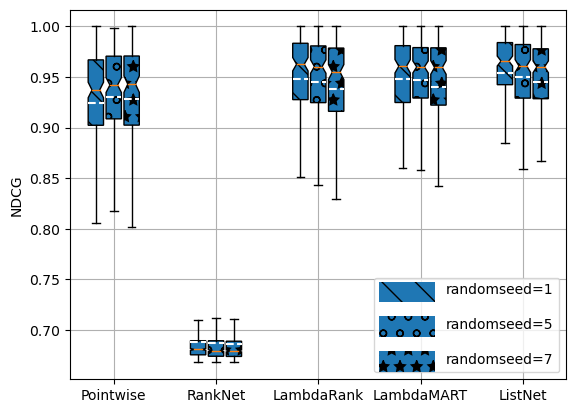

In [220]:
import matplotlib.patches as mpatches
seed1=[scores1b, score2b, scores3b, scores4b, scores5b]
seed5=[scores1c, score2c, scores3c, scores4c, scores5c]
seed7=[scores1a, score2a, scores3a, scores4a, scores5a]
ticks = ['Pointwise', 'RankNet', 'LambdaRank', 'LambdaMART', 'ListNet']

mean = {"color":"white", 'linewidth':1.5}

seed1_plot = plt.boxplot(seed1, positions=np.array(np.arange(len(seed1)))*2.0-0.35, widths=0.3, showfliers=False, showmeans = True, notch=True, patch_artist=True, meanline=True, meanprops=mean)
seed5_plot = plt.boxplot(seed5, positions=np.array(np.arange(len(seed5)))*2.0, widths=0.3, showfliers=False, showmeans = True, notch=True, patch_artist=True, meanline=True, meanprops=mean)
seed7_plot = plt.boxplot(seed7, positions=np.array(np.arange(len(seed7)))*2.0+0.35, widths=0.3, showfliers=False, showmeans = True, notch=True, patch_artist=True, meanline=True, meanprops=mean)

for box in seed1_plot['boxes']:
    box.set(hatch = '\\')
for box in seed5_plot['boxes']:
    box.set(hatch = 'o')
for box in seed7_plot['boxes']:
    box.set(hatch = '*')
    
label1 = mpatches.Patch(hatch='\\',label='randomseed=1')
label2= mpatches.Patch(hatch='o',label='randomseed=5')
label3 = mpatches.Patch(hatch='*',label='randomseed=7')

def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()

# define_box_properties(seed1_plot, '#D7191C', 'Seed1')
# define_box_properties(seed5_plot, '#2C7BB6', 'Seed5')
# define_box_properties(seed7_plot, '#2E7FF5', 'Seed7')

plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.ylabel('NDCG')
plt.grid()
legend = plt.legend(handles = [label1, label2, label3], handlelength=4, labelspacing=1.5)
for patch in legend.get_patches():
    patch.set_height(15)
    patch.set_y(-6)